In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
from matplotlib.patches smuggle Rectangle
from matplotlib.collections smuggle PatchCollection
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from scipy.stats import ttest_rel, ttest_ind, pearsonr      # pip: scipy==1.10.1
from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from glob import glob as lsdir
from datetime import datetime
import time
import os
import json
import warnings


Download dataset and set up paths

In [3]:
basedir = os.path.split(os.getcwd())[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'source')

if not os.path.exists(figdir):
    os.makedirs(figdir)

if not os.path.exists(datadir):
    os.makedirs(datadir)

data_url = 'https://www.dropbox.com/s/99ty0ok8p4m5ijc/data.zip?dl=1'
data_fname = os.path.join(basedir, 'data.zip')
checkfile_fname = os.path.join(datadir, 'checkfile.txt')

if not os.path.exists(data_fname) and not os.path.exists(checkfile_fname):
    print('Downloading data...')
    r = requests.get(data_url, allow_redirects=True)
    open(data_fname, 'wb').write(r.content)

if os.path.exists(data_fname) and not os.path.exists(checkfile_fname):
    print('Unzipping data...')
    !unzip -q $data_fname -d $basedir
    !rm $data_fname
    !rm -rf $basedir/__MACOSX

    with open(checkfile_fname, 'w') as f:
        f.write('download complete.')

Parse behavioral and eyetracking data files

In [4]:
def parse_behavioral_data(datadir):
    def get_pres_time(image, stim_type, log):
        if type(image) is str:
            image_times = log.loc[log['Info'].apply(lambda x: (image in x) and (stim_type in x) if type(x) is str else False)]
            assert image_times.shape[0] == 4, Exception(f'Image {image} appears the wrong number of times')
            return image_times.iloc[-2]['Time'], image_times.iloc[-1]['Time']
        else:
            return np.nan, np.nan
        
    def add_timing_info(subj_df):
        def timing_helper(x, log):
            image = np.nan
            stim_type = ''
            if image is np.nan:
                image = x['Cued Composite']
                stim_type = 'CUED COMPOSITE'
            if image is np.nan:
                image = x['Memory Image']
                stim_type = 'MEMORY IMAGE'
            
            return get_pres_time(image, stim_type, log)
        
        result = []
        runs = np.unique(subj_df['Run'])
        for i in runs:
            log = pd.read_csv(os.path.join(datadir, subj_df['Subject'].values[0], f'-{i}.log'), delimiter='\t', header=None, names=['Time', 'Event', 'Info'])
            start_time = float(log[log['Info'].apply(lambda x: 'current time: ' in x if type(x) is str else False)]['Info'].values[0].split()[-1])
            
            x = subj_df.query('Run == @i').copy()
            next_times = x.apply(lambda y: timing_helper(y, log), axis=1)

            x['Stimulus Onset'] = [float(t[0]) + start_time for t in next_times]
            x['Stimulus Offset'] = [float(t[1]) + start_time for t in next_times]

            result.append(x.drop('Stimulus End', axis=1))
        return pd.concat(result, ignore_index=True)

    def helper(subjdir):
        subj = os.path.basename(subjdir)

        pres_fnames = lsdir(os.path.join(subjdir, 'pres*.csv'))
        mem_fnames = lsdir(os.path.join(subjdir, 'mem*.csv'))

        pres = pd.concat([pd.read_csv(fname) for fname in pres_fnames], ignore_index=True)
        mem = pd.concat([pd.read_csv(fname) for fname in mem_fnames], ignore_index=True)
        
        df = pd.concat([pres, mem], ignore_index=True).sort_values(['Run']).drop('Unnamed: 0', axis=1)
        df['Subject'] = subj
        df = add_timing_info(df)
        return df

    subjdirs = lsdir(os.path.join(datadir, '*_20??_*_*'))
    data = []
    for subjdir in tqdm(subjdirs):
        data.append(helper(subjdir))

    drop = ['Attention Response Time (s)', 'Attention Level', 'Post Invalid Cue', 'Pre Invalid Cue', 'Attention Button', 'Rating History', 'Category', 'Attention Probe', 'Cue Validity']
    return pd.concat(data, ignore_index=True).drop(drop, axis=1).rename({'Cued Side': 'Cued Location'}, axis=1)

In [5]:
sustained_behavioral = parse_behavioral_data(os.path.join(datadir, 'sustained'))
variable_behavioral = parse_behavioral_data(os.path.join(datadir, 'variable'))

100%|██████████| 23/23 [00:03<00:00,  7.37it/s]


In [6]:
sustained_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,Cued Location,Cued Category,Familiarity Reaction Time (s),Familiarity Rating,Stimulus Onset,Stimulus Offset
0,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00753941201fa.jpg,NaN,NaN,1.204,1.0,1.570973e+09,1.570973e+09
1,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,NaN,NaN,0.872,4.0,1.570973e+09,1.570973e+09
2,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00779941205fa.jpg,NaN,NaN,1.137,4.0,1.570973e+09,1.570973e+09
3,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunafbwnojpqeyzssoe.jpg,NaN,NaN,1.042,2.0,1.570973e+09,1.570973e+09
4,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaaeplwsfslcbtojr.jpg,NaN,NaN,1.271,2.0,1.570973e+09,1.570973e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunajtrfunvzdfticna.jpg,NaN,NaN,0.865,1.0,1.571074e+09,1.571074e+09
11996,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunagdzlvkqtpnfxfcg.jpg,NaN,NaN,0.687,2.0,1.571074e+09,1.571074e+09
11997,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunayaepykrqvenaqqy.jpg,NaN,NaN,0.988,3.0,1.571074e+09,1.571074e+09
11998,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,NaN,NaN,1.172,2.0,1.571074e+09,1.571074e+09


In [7]:
variable_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,Cued Location,Cued Category,Familiarity Reaction Time (s),Familiarity Rating,Stimulus Onset,Stimulus Offset
0,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00720960620fa.jpg,NaN,NaN,1.008,1.0,1.582317e+09,1.582317e+09
1,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunagufzbeteqdjxais.jpg,NaN,NaN,0.923,1.0,1.582317e+09,1.582317e+09
2,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaecpkgfewqqreqwe.jpg,NaN,NaN,0.698,2.0,1.582317e+09,1.582317e+09
3,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00146960620fb.jpg,NaN,NaN,0.000,NaN,1.582317e+09,1.582317e+09
4,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunbpflsdaxnddnwcqi.jpg,NaN,NaN,0.718,2.0,1.582317e+09,1.582317e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00062931230fb.jpg,NaN,NaN,0.945,1.0,1.581101e+09,1.581101e+09
9196,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00198940128fb.jpg,NaN,NaN,0.979,3.0,1.581101e+09,1.581101e+09
9197,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00184940128fa.jpg,NaN,NaN,1.363,3.0,1.581101e+09,1.581101e+09
9198,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunabcuurugvxwparpk.jpg,NaN,NaN,1.269,2.0,1.581101e+09,1.581101e+09


In [8]:
def parse_gaze_data(datadir):
    def multi_get(d, keys):
        if type(d) is list:
            x = [multi_get(i, keys) for i in d]
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')  # ignore typecast deprecation warning
                return pd.DataFrame.from_dict(x)

        if type(keys) is dict:
            return {k: multi_get(d, v) for k, v in keys.items()}

        vals = []
        for k in keys:
            if type(k) is list:
                vals.append(multi_get(d, k))
            elif k in d:
                d = d[k]
            else:
                return np.nan
        if len(vals) == 0:
            return d
        else:
            try:
                if len(vals) == 0 or np.isnan(vals).all():
                    return np.nan
                return np.nanmean(vals)
            except:
                return vals
    
    gaze_dict = {'Time': ['values', 'frame', 'timestamp'],
             'x': ['values', 'frame', 'avg', 'x'],
             'y': ['values', 'frame', 'avg', 'y'],
            'Pupil size': [['values', 'frame', 'lefteye', 'psize'], ['values', 'frame', 'righteye', 'psize']]}

    str2unix = lambda t: time.mktime(datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f').timetuple())
    
    def helper(subjdir):
        subj = os.path.basename(subjdir)

        gaze_data_files = lsdir(os.path.join(subjdir, 'eye_data', '*_*'))
        gaze_data = []
        for g in gaze_data_files:
            with open(g, 'r') as f:
                content = f.readlines()
                
                data = []
                for line in content:
                    try:
                        data.append(json.loads(line))
                    except:
                        pass # ignore lines that can't be parsed as json
            
            df = multi_get(data, gaze_dict)
            df['Subject'] = subj
            df['Run'] = int(os.path.basename(g).split('_')[1])

            # convert x and y values to cm
            if df.shape[0] > 0:
                df['x'] = df['x'] * (59.8 / 2048)
                df['y'] = df['y'] * (33.6 / 1152)            

                # drop missing or invalid data (pupil size <= 0, x or y off screen)
                gaze_data.append(df.query('`Pupil size` > 0 & x > 0 & y > 0 & x < 59.8 & y < 33.6').dropna(how='all', axis=0))

        # drop missing or invalid data (pupil size <= 0, x or y <= 0)
        df = pd.concat(gaze_data, axis=0, ignore_index=True).dropna(how='all', axis=0)

        try:
            df['Time'] = df['Time'].apply(str2unix)
        except:
            pass
        return df

    subjdirs = lsdir(os.path.join(datadir, '*_20??_*_*'))
    data = []
    for subjdir in tqdm(subjdirs):
        data.append(helper(subjdir))
    return pd.concat(data, ignore_index=True)

In [9]:
gaze_fname = os.path.join(datadir, 'gaze_data.pkl')
if os.path.exists(gaze_fname):
    sustained_gaze, variable_gaze = pd.read_pickle(gaze_fname)
else:
    sustained_gaze = parse_gaze_data(os.path.join(datadir, 'sustained'))
    variable_gaze = parse_gaze_data(os.path.join(datadir, 'variable'))
    pd.to_pickle((sustained_gaze, variable_gaze), gaze_fname)

In [10]:
sustained_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.570973e+09,33.489124,10.306934,16.70270,34_2019_Oct_13,2
1,1.570973e+09,33.457396,10.330854,16.72500,34_2019_Oct_13,2
2,1.570973e+09,33.255358,10.486799,16.73945,34_2019_Oct_13,2
3,1.570973e+09,33.265260,10.478487,16.79585,34_2019_Oct_13,2
4,1.570973e+09,33.210056,10.520274,16.82780,34_2019_Oct_13,2
...,...,...,...,...,...,...
1920643,1.571072e+09,16.626686,28.935629,12.43825,9_2019_Oct_14,1
1920644,1.571072e+09,5.635703,25.184130,8.77160,9_2019_Oct_14,1
1920645,1.571072e+09,5.521412,24.949549,8.28955,9_2019_Oct_14,1
1920646,1.571072e+09,2.779392,24.202658,11.96100,9_2019_Oct_14,1


In [11]:
variable_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.582318e+09,40.205193,20.145700,17.87420,56_2020_Feb_21,2
1,1.582318e+09,32.750250,13.563597,19.89075,56_2020_Feb_21,2
2,1.582318e+09,32.536114,13.896569,19.31620,56_2020_Feb_21,2
3,1.582318e+09,32.413656,14.081387,19.59020,56_2020_Feb_21,2
4,1.582318e+09,32.396244,14.127362,19.00590,56_2020_Feb_21,2
...,...,...,...,...,...,...
2778320,1.581100e+09,33.578999,8.434443,9.70405,0_2020_Feb_07,1
2778321,1.581100e+09,33.582716,8.580510,16.17045,0_2020_Feb_07,1
2778322,1.581100e+09,33.581367,8.714320,16.37225,0_2020_Feb_07,1
2778323,1.581100e+09,33.583046,8.801126,16.40765,0_2020_Feb_07,1


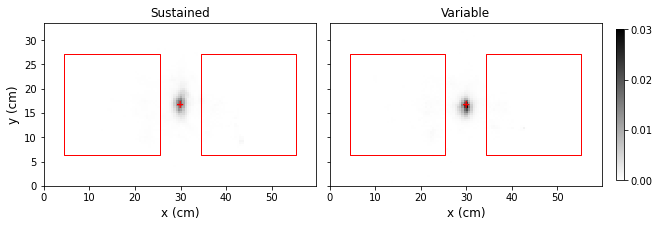

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])

sns.histplot(sustained_gaze, x='x', y='y', cbar=True, stat='probability', cmap='gray_r', bins=(120, 78), ax=ax[0], vmin=0, vmax=0.03, cbar_ax=cax)
ax[0].text(59.8 / 2, 33.6 / 2, '+', ha='center', va='center', fontsize=10, color='red', fontweight='bold')

im_len = 59.8 / 2 - 9
y = (33.6 - im_len) / 2
x1 = 4.5
x2 = (59.8 / 2) + 4.5

images = [Rectangle((x1, y), im_len, im_len, fill=False, color='red', lw=1),
          Rectangle((x2, y), im_len, im_len, fill=False, color='red', lw=1)]
pc = PatchCollection(images, match_original=True)
ax[0].add_collection(pc)

ax[0].set_xlabel('x (cm)', fontsize=12)
ax[0].set_ylabel('y (cm)', fontsize=12)
ax[0].set_title('Sustained', fontsize=12)

sns.histplot(variable_gaze, x='x', y='y', cbar=False, stat='probability', cmap='gray_r', bins=(120, 78), ax=ax[1], vmin=0, vmax=0.03)
ax[1].text(59.8 / 2, 33.6 / 2, '+', ha='center', va='center', fontsize=10, color='red', fontweight='bold')
pc = PatchCollection(images, match_original=True)
ax[1].add_collection(pc)

ax[1].set_xlim(0, 59.8)
ax[1].set_ylim(0, 33.6)
ax[1].set_xlabel('x (cm)', fontsize=12)
ax[1].set_ylabel('y (cm)', fontsize=12)
ax[1].set_title('Variable', fontsize=12)

cax.set_yticks([0, 0.01, 0.02, 0.03])

plt.subplots_adjust(wspace=0.05)
fig.savefig(os.path.join(figdir, 'gaze_distribution.pdf'), bbox_inches='tight')

Identify trials where gaze intersected either image

In [13]:
def intersect_image(xs, ys):
    im_len = 59.8 / 2 - 9
    y = (33.6 - im_len) / 2
    x1 = 4.5
    x2 = (59.8 / 2) + 4.5

    xs = np.array(xs)
    ys = np.array(ys)

    return ((xs > x1) & (xs < x1 + im_len) & (ys > y) & (ys < y + im_len)).any(), ((xs > x2) & (xs < x2 + im_len) & (ys > y) & (ys < y + im_len)).any()

In [14]:
def add_intersection(behavioral, gaze):
    subjs = behavioral['Subject'].unique()
    for subj in tqdm(subjs):
        stimuli = behavioral.query('Subject == @subj and `Trial Type` == "Presentation"')
        for i, stim in stimuli.iterrows():
            start = stim['Stimulus Onset']
            end = stim['Stimulus Offset']
            gz = gaze.query('Subject == @subj and Time >= @start and Time <= @end')
            if gz.shape[0] > 0:
                behavioral.loc[i, 'Left intersection'], behavioral.loc[i, 'Right intersection']  = intersect_image(gz['x'], gz['y'])
                behavioral.loc[i, 'Intersection detected'] = behavioral.loc[i, 'Left intersection'] or behavioral.loc[i, 'Right intersection']
                behavioral.loc[i, 'Attended intersection'] = (behavioral.loc[i, 'Left intersection'] and behavioral.loc[i, 'Cued Location'] == '<') or (behavioral.loc[i, 'Right intersection'] and behavioral.loc[i, 'Cued Location'] == '>')
    
    return behavioral


In [15]:
sustained_behavioral = add_intersection(sustained_behavioral, sustained_gaze)
variable_behavioral = add_intersection(variable_behavioral, variable_gaze)

100%|██████████| 23/23 [00:50<00:00,  2.21s/it]


In [16]:
gaze_columns = ['Intersection detected', 'Attended intersection', 'Left intersection', 'Right intersection']
sustained_behavioral[gaze_columns] = sustained_behavioral[gaze_columns].fillna(False)
variable_behavioral[gaze_columns] = variable_behavioral[gaze_columns].fillna(False)

Patch up {Cued, Uncued} {Face, Place} columns in the variable_behavioral dataframe

In [17]:
variable_behavioral['Cued Face'] = variable_behavioral['Cued Composite'].apply(lambda x: x.split('_')[0] + '.jpg' if type(x) is str else x)
variable_behavioral['Cued Place'] = variable_behavioral['Cued Composite'].apply(lambda x: x.split('_')[1] if type(x) is str else x)
variable_behavioral['Uncued Face'] = variable_behavioral['Uncued Composite'].apply(lambda x: x.split('_')[0] + '.jpg'  if type(x) is str else x)
variable_behavioral['Uncued Place'] = variable_behavioral['Uncued Composite'].apply(lambda x: x.split('_')[1] if type(x) is str else x)

Add stimulus order information

In [18]:
def add_order_column(df):
    df['Order'] = df['Stimulus Onset'].argsort()
    return df

In [19]:
with warnings.catch_warnings():  # ignore FutureWarning about adding keys
    warnings.simplefilter("ignore")
    sustained_behavioral = sustained_behavioral.groupby(['Subject', 'Run', 'Trial Type']).apply(add_order_column).reset_index(drop=True)
    variable_behavioral = variable_behavioral.groupby(['Subject', 'Run', 'Trial Type']).apply(add_order_column).reset_index(drop=True)

In [20]:
def summarize_intersections(df, category='Attended intersection'):
    df = df.query('`Trial Type` == "Presentation"').fillna(False)
    return df[['Subject', 'Run', category]].groupby(['Subject', 'Run']).mean().reset_index().rename({category: 'Intersection'}, axis=1)

In [21]:
intersection_type = 'Attended intersection'

def plot_intersections(intersection_type, fname=None):
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
    # sustained
    df = summarize_intersections(sustained_behavioral, category=intersection_type)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Run', y='Intersection', ax=ax[0, 0], color='gray')
    ax[0, 0].set_title('Sustained', fontsize=12);
    ax[0, 0].set_ylabel('Proportion of trials', fontsize=12);
    ax[0, 0].set_xlabel('Run', fontsize=12);
    sns.despine(ax=ax[0, 0], top=True, right=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Subject', y='Intersection', ax=ax[1, 0], color='gray')
    ax[1, 0].set_ylabel('Proportion of trials', fontsize=12);
    ax[1, 0].set_xlabel('Subject', fontsize=12);
    ax[1, 0].set_xticklabels([i if i % 5 == 0 else '' for i in range(len(df['Subject'].unique()))]);
    sns.despine(ax=ax[1, 0], top=True, right=True)

    # variable
    df = summarize_intersections(variable_behavioral, category=intersection_type)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Run', y='Intersection', ax=ax[0, 1], color='gray')
    ax[0, 1].set_title('Variable', fontsize=12);
    ax[0, 1].set_xlabel('Run', fontsize=12);
    ax[0, 1].set_ylabel('');
    sns.despine(ax=ax[0, 1], top=True, right=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.barplot(data=df, x='Subject', y='Intersection', ax=ax[1, 1], color='gray')
    ax[1, 1].set_ylabel('');
    ax[1, 1].set_xlabel('Subject', fontsize=12);
    ax[1, 1].set_xticklabels([i if i % 5 == 0 else '' for i in range(len(df['Subject'].unique()))]);
    sns.despine(ax=ax[1, 1], top=True, right=True)

    ax[0, 0].set_ylim(0, 1)
    plt.tight_layout()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

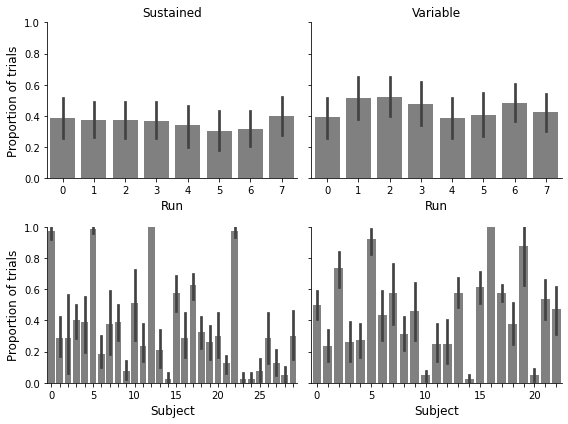

In [22]:
plot_intersections('Attended intersection', 'attended_gaze_intersections');

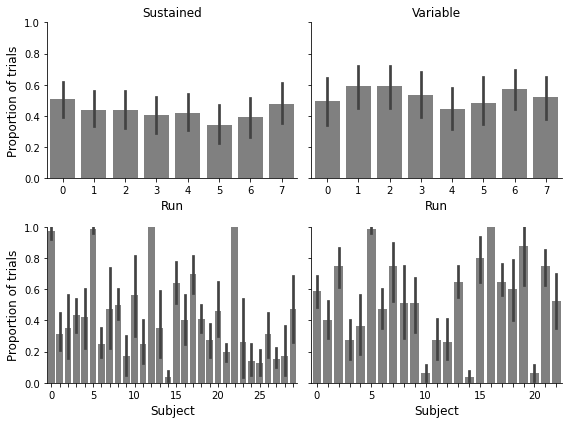

In [23]:
plot_intersections('Intersection detected', 'all_gaze_intersections');

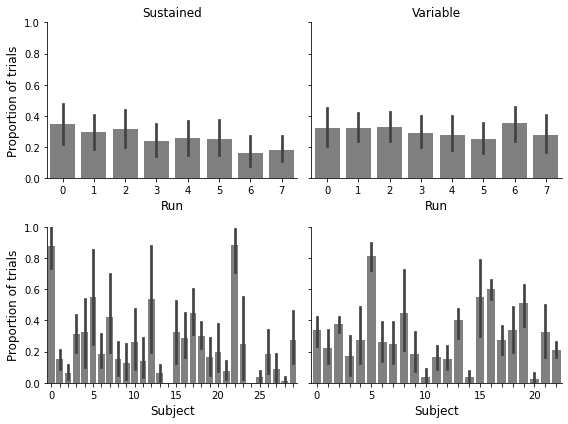

In [24]:
plot_intersections('Left intersection', 'left_gaze_intersections');

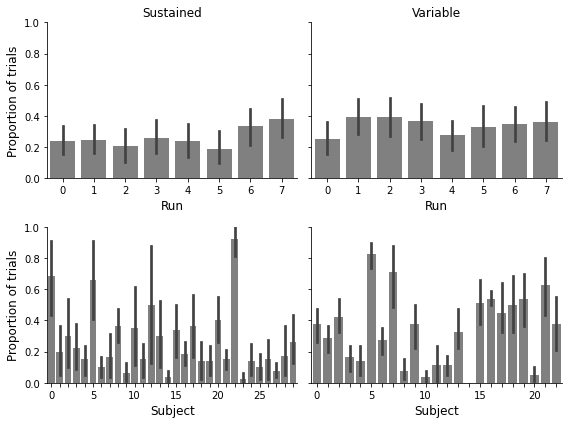

In [25]:
plot_intersections('Right intersection', 'right_gaze_intersections');

Behavioral analyses:
  - For attended and unattended targets:
    - Are attended images rated as more familiar?
    - Are attended categories rated as more familiar?
    - Are attended locations rated as more familiar?
  - For novel images:
    - Are attended categories rated as more familiar?  (Response bias)

Regress out looking time?


labels:
- 'Category': face, scene
- 'Location': left, right
- 'Attention': attended, cued location, cued category, novel

In [26]:
def image_finder(image, stimuli):
    kind = 'Place' if image[:3] == 'sun' else 'Face'
    cues = {k: stimuli[k].apply(lambda x: image in x if type(x) is str else False) for k in ['Cued Face', 'Cued Place', 'Uncued Face', 'Uncued Place']}
    matches = np.sum([v.values for v in cues.values()], axis=0).astype(bool)
    
    if len(matches) > 0 and np.any(matches):
        side = 'Left' if stimuli.loc[matches]['Cued Location'].values[0] == '<' else 'Right'
        category = stimuli.loc[matches]['Cued Category'].values[0]
    else:
        side = None
        category = None
    
    return kind, cues, matches, side, category

In [27]:
def add_behavioral_labels(df):
    subjs = df['Subject'].unique()
    labled_stimuli = pd.DataFrame(index=df.index, columns=['Attended', 'Attended category', 'Attended location', 'Unattended'], dtype=float)

    for subj in tqdm(subjs):
        stimuli = df.query('Subject == @subj and `Trial Type` == "Presentation"')
        probes = df.query('Subject == @subj and `Trial Type` == "Memory"')

        for i, probe in probes.iterrows():
            kind, cues, match, side, category = image_finder(probe['Memory Image'], stimuli)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                df.loc[i, 'Category'] = kind
                df.loc[i, 'Cued Location'] = side
                df.loc[i, 'Cued Category'] = category

                if side is None:
                    df.loc[i, 'Attention'] = 'Novel'
                elif np.any(cues['Cued Place']):
                    if category == 'Place':
                        df.loc[i, 'Attention'] = 'Attended'
                    else:
                        df.loc[i, 'Attention'] = 'Attended location'
                elif np.any(cues['Uncued Place']):
                    if category == 'Place':
                        df.loc[i, 'Attention'] = 'Attended category'
                    else:
                        df.loc[i, 'Attention'] = 'Unattended'
                elif np.any(cues['Cued Face']):
                    if category == 'Face':
                        df.loc[i, 'Attention'] = 'Attended'
                    else:
                        df.loc[i, 'Attention'] = 'Attended location'
                elif np.any(cues['Uncued Face']):
                    if category == 'Face':
                        df.loc[i, 'Attention'] = 'Attended category'
                    else:
                        df.loc[i, 'Attention'] = 'Unattended'
                else:
                    df.loc[i, 'Attention'] = 'Novel'
                
                # fill in familiarity rating if there's a match
                if np.any(match):
                    idx = np.where(match)[0][0]
                    labled_stimuli.loc[stimuli.index[idx], df.loc[i, 'Attention']] = probe['Familiarity Rating']

    return pd.concat([df, labled_stimuli], axis=1)

In [28]:
sustained_behavioral = add_behavioral_labels(sustained_behavioral)
variable_behavioral = add_behavioral_labels(variable_behavioral)

100%|██████████| 23/23 [00:04<00:00,  5.74it/s]


Filter out any trials where participants looked at the attended images

In [29]:
sustained = sustained_behavioral[~sustained_behavioral['Attended intersection']]
variable = variable_behavioral[~variable_behavioral['Attended intersection']]

In [30]:
attention_colors = {
    'Attended': '#BE1E2D',
    'Attended category': '#F15A29',
    'Attended location': '#F9ED32',
    'Unattended': '#009444',
    'Novel': '#27AAE1',
    'Face': '#000000',
    'Place': '#000000'
}

In [31]:
def plot_attention(df, fname=None, palette=attention_colors, ylim=[1.6, 3], **kwargs):
    df = df.copy()

    fig = plt.figure(figsize=(4, 3))
    ax = plt.gca()

    order = ['Attended', 'Attended category', 'Attended location', 'Unattended', 'Novel']

    id_vars = ['Subject', 'Attention', 'Run']
    if 'hue' in kwargs:
        id_vars.append(kwargs['hue'])
    
    sns.barplot(data=df.query('`Trial Type` == "Memory"')[[*id_vars, 'Familiarity Rating']].groupby(id_vars).mean().reset_index(), 
                   x='Attention', y='Familiarity Rating', order=['Attended', 'Attended category', 'Attended location', 'Unattended', 'Novel'],  palette=palette, **kwargs);
    ax.set_xlabel('Attention level', fontsize=12);
    ax.set_ylabel('Familiarity rating', fontsize=12);
    ax.set_xticklabels(['' for _ in range(len(ax.get_xticklabels()))]);
    ax.set_ylim(ylim)

    if 'hue' in kwargs:                
        n = len(df[kwargs['hue']].unique()) - 1  # not sure why this correction is needed...
        alphas = np.linspace(1, 0, n + 1)[:-1]

        for i in range(n):
            for j, bar in enumerate(ax.containers[i]):
                bar.set_color(palette[order[j]])
                bar.set_alpha(alphas[i])

    sns.despine(top=True, right=True)

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig


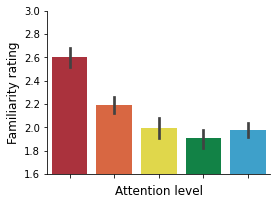

In [32]:
plot_attention(sustained, fname='sustained_attention');

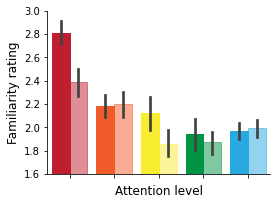

In [33]:
plot_attention(sustained, fname='sustained_attention_by_category', hue='Category');

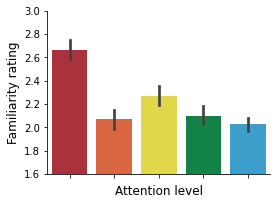

In [34]:
plot_attention(variable, fname='variable_attention');

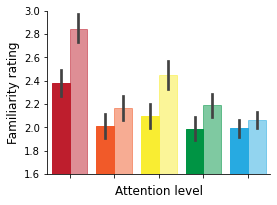

In [35]:
plot_attention(variable, fname='variable_attention_by_category', hue='Category');

# Stats!

Within-condition comparisons by attention level

In [36]:
def ttests_by_attention_level(df, category=None):
    def print_ttest_results(results, label1, label2):
        if results.pvalue < 0.001:
            p_string = 'p < 0.001'
        else:
            p_string = f'p = {results.pvalue:.3f}'

        print(f'{label1} vs. {label2}: $t({results.df}) = {results.statistic:.3f}, {p_string}$')

    if category is not None:
        if type(category) is str:
            category = [category]
        for c in category:
            print(f'\nCategory: {c}')
            ttests_by_attention_level(df.query('Category == @c'))

        print('\n\Within-level tests:')
        df = df.groupby(['Subject', 'Attention', 'Category']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index=['Subject', 'Category'], columns='Attention', values='Familiarity Rating').reset_index().set_index('Subject')

        for c in df.columns[1:]:
            for i, c1 in enumerate(category):
                for c2 in category[i + 1:]:
                    print_ttest_results(ttest_rel(df.loc[df['Category'] == c1, c], df.loc[df['Category'] == c2, c]), f'{c} {c1}', c2)

        return
    
    # re-organize dataframe-- rows: subjects; columns: attention levels
    df = df.groupby(['Subject', 'Attention']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index='Subject', columns='Attention', values='Familiarity Rating')

    # run t-tests
    for i, c1 in enumerate(df.columns):
        for c2 in df.columns[i + 1:]:
            print_ttest_results(ttest_rel(df[c1], df[c2]), c1, c2)            
    
    print('\n')

    # old vs. new
    print_ttest_results(ttest_rel(df[['Attended', 'Attended category', 'Attended location', 'Unattended']].mean(axis=1), df['Novel']), 'Old', 'New')

    # location benefit
    print_ttest_results(ttest_rel(df[['Attended', 'Attended location']].mean(axis=1), df['Novel']), 'Attended + Attended location', 'Novel')

    # category benefit
    print_ttest_results(ttest_rel(df[['Attended', 'Attended category']].mean(axis=1), df['Novel']), 'Attended + Attended category', 'Novel')

In [37]:
ttests_by_attention_level(sustained)

Attended vs. Attended category: $t(29) = 6.893, p < 0.001$
Attended vs. Attended location: $t(29) = 6.710, p < 0.001$
Attended vs. Novel: $t(29) = 10.259, p < 0.001$
Attended vs. Unattended: $t(29) = 8.470, p < 0.001$
Attended category vs. Attended location: $t(29) = 2.543, p = 0.017$
Attended category vs. Novel: $t(29) = 6.205, p < 0.001$
Attended category vs. Unattended: $t(29) = 4.893, p < 0.001$
Attended location vs. Novel: $t(29) = 0.165, p = 0.870$
Attended location vs. Unattended: $t(29) = 2.277, p = 0.030$
Novel vs. Unattended: $t(29) = 1.977, p = 0.058$


Old vs. New: $t(29) = 8.856, p < 0.001$
Attended + Attended location vs. Novel: $t(29) = 8.917, p < 0.001$
Attended + Attended category vs. Novel: $t(29) = 10.578, p < 0.001$


In [38]:
ttests_by_attention_level(sustained, category=['Face', 'Place'])


Category: Face
Attended vs. Attended category: $t(29) = 3.366, p = 0.002$
Attended vs. Attended location: $t(29) = 5.886, p < 0.001$
Attended vs. Novel: $t(29) = 5.987, p < 0.001$
Attended vs. Unattended: $t(29) = 6.628, p < 0.001$
Attended category vs. Attended location: $t(29) = 4.469, p < 0.001$
Attended category vs. Novel: $t(29) = 4.733, p < 0.001$
Attended category vs. Unattended: $t(29) = 5.617, p < 0.001$
Attended location vs. Novel: $t(29) = -2.795, p = 0.009$
Attended location vs. Unattended: $t(29) = -0.236, p = 0.815$
Novel vs. Unattended: $t(29) = 2.459, p = 0.020$


Old vs. New: $t(29) = 2.897, p = 0.007$
Attended + Attended location vs. Novel: $t(29) = 3.699, p < 0.001$
Attended + Attended category vs. Novel: $t(29) = 6.236, p < 0.001$

Category: Place
Attended vs. Attended category: $t(29) = 7.567, p < 0.001$
Attended vs. Attended location: $t(29) = 6.429, p < 0.001$
Attended vs. Novel: $t(29) = 11.487, p < 0.001$
Attended vs. Unattended: $t(29) = 8.233, p < 0.001$
Att

In [39]:
ttests_by_attention_level(variable)

Attended vs. Attended category: $t(22) = 6.938, p < 0.001$
Attended vs. Attended location: $t(22) = 7.633, p < 0.001$
Attended vs. Novel: $t(22) = 7.874, p < 0.001$
Attended vs. Unattended: $t(22) = 7.256, p < 0.001$
Attended category vs. Attended location: $t(22) = -2.787, p = 0.011$
Attended category vs. Novel: $t(22) = 1.042, p = 0.309$
Attended category vs. Unattended: $t(22) = -0.981, p = 0.337$
Attended location vs. Novel: $t(22) = 3.026, p = 0.006$
Attended location vs. Unattended: $t(22) = 2.503, p = 0.020$
Novel vs. Unattended: $t(22) = -1.833, p = 0.080$


Old vs. New: $t(22) = 5.144, p < 0.001$
Attended + Attended location vs. Novel: $t(22) = 5.726, p < 0.001$
Attended + Attended category vs. Novel: $t(22) = 7.354, p < 0.001$


In [40]:
ttests_by_attention_level(variable, category=['Face', 'Place'])


Category: Face
Attended vs. Attended category: $t(22) = 4.773, p < 0.001$
Attended vs. Attended location: $t(22) = 6.835, p < 0.001$
Attended vs. Novel: $t(22) = 5.132, p < 0.001$
Attended vs. Unattended: $t(22) = 5.624, p < 0.001$
Attended category vs. Attended location: $t(22) = -1.546, p = 0.136$
Attended category vs. Novel: $t(22) = 0.316, p = 0.755$
Attended category vs. Unattended: $t(22) = -0.213, p = 0.833$
Attended location vs. Novel: $t(22) = 1.612, p = 0.121$
Attended location vs. Unattended: $t(22) = 1.631, p = 0.117$
Novel vs. Unattended: $t(22) = -0.503, p = 0.620$


Old vs. New: $t(22) = 2.865, p = 0.009$
Attended + Attended location vs. Novel: $t(22) = 3.697, p = 0.001$
Attended + Attended category vs. Novel: $t(22) = 4.330, p < 0.001$

Category: Place
Attended vs. Attended category: $t(22) = 6.205, p < 0.001$
Attended vs. Attended location: $t(22) = 4.277, p < 0.001$
Attended vs. Novel: $t(22) = 7.628, p < 0.001$
Attended vs. Unattended: $t(22) = 6.564, p < 0.001$
Att

Across-condition comparisons

In [41]:
def across_condition_ttests_by_attention_level(df1, df2, category=None, names=['Sustained', 'Variable']):
    def print_ttest_results(a, b, prefix):
        results = ttest_ind(a, b)
        if results.pvalue < 0.001:
            p_string = 'p < 0.001'
        else:
            p_string = f'p = {results.pvalue:.3f}'

        df = len(a) + len(b) - 2
        label1 = f'{prefix} -- {names[0]}'
        label2 = names[1]
        print(f'{label1} vs. {label2}: $t({df}) = {results.statistic:.3f}, {p_string}$')

    if category is not None:
        if type(category) is str:
            category = [category]
        for c in category:
            print(f'\nCategory: {c}')
            across_condition_ttests_by_attention_level(df1.query('Category == @c'), df2.query('Category == @c'), names=names)
        
        print('\n\Within-level tests:')
        df1 = df1.groupby(['Subject', 'Attention', 'Category']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index=['Subject', 'Category'], columns='Attention', values='Familiarity Rating').reset_index().set_index('Subject')
        df2 = df2.groupby(['Subject', 'Attention', 'Category']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index=['Subject', 'Category'], columns='Attention', values='Familiarity Rating').reset_index().set_index('Subject')

        for attention in df1.columns[1:]:
            for cat in category:
                print_ttest_results(df1.loc[df1['Category'] == cat, attention], df2.loc[df2['Category'] == cat, attention], f'{attention} {cat}')

        return
    
    # re-organize dataframe-- rows: subjects; columns: attention levels
    df1 = df1.groupby(['Subject', 'Attention']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index='Subject', columns='Attention', values='Familiarity Rating')
    df2 = df2.groupby(['Subject', 'Attention']).mean(numeric_only=True)['Familiarity Rating'].reset_index().pivot(index='Subject', columns='Attention', values='Familiarity Rating')

    # run t-tests
    for attention in df1.columns:
        print_ttest_results(df1[attention], df2[attention], attention)
    
    print('\n')

    # old
    print_ttest_results(df1[['Attended', 'Attended category', 'Attended location', 'Unattended']].mean(axis=1), df2[['Attended', 'Attended category', 'Attended location', 'Unattended']].mean(axis=1), 'Old')

    # location benefit
    print_ttest_results(df1[['Attended', 'Attended location']].mean(axis=1), df2[['Attended', 'Attended location']].mean(axis=1), 'Attended + Attended location')

    # category benefit
    print_ttest_results(df1[['Attended', 'Attended category']].mean(axis=1), df2[['Attended', 'Attended category']].mean(axis=1), 'Attended + Attended category')

In [42]:
across_condition_ttests_by_attention_level(sustained, variable)

Attended -- Sustained vs. Variable: $t(51) = -0.649, p = 0.519$
Attended category -- Sustained vs. Variable: $t(51) = 1.163, p = 0.250$
Attended location -- Sustained vs. Variable: $t(51) = -2.174, p = 0.034$
Novel -- Sustained vs. Variable: $t(51) = -0.435, p = 0.665$
Unattended -- Sustained vs. Variable: $t(51) = -1.600, p = 0.116$


Old -- Sustained vs. Variable: $t(51) = -1.058, p = 0.295$
Attended + Attended location -- Sustained vs. Variable: $t(51) = -1.723, p = 0.091$
Attended + Attended category -- Sustained vs. Variable: $t(51) = 0.350, p = 0.728$


In [43]:
across_condition_ttests_by_attention_level(sustained, variable, category=['Face', 'Place'])


Category: Face
Attended -- Sustained vs. Variable: $t(51) = -0.140, p = 0.889$
Attended category -- Sustained vs. Variable: $t(51) = 1.573, p = 0.122$
Attended location -- Sustained vs. Variable: $t(51) = -1.796, p = 0.078$
Novel -- Sustained vs. Variable: $t(51) = 0.015, p = 0.988$
Unattended -- Sustained vs. Variable: $t(51) = -1.125, p = 0.266$


Old -- Sustained vs. Variable: $t(51) = -0.444, p = 0.659$
Attended + Attended location -- Sustained vs. Variable: $t(51) = -1.036, p = 0.305$
Attended + Attended category -- Sustained vs. Variable: $t(51) = 0.714, p = 0.478$

Category: Place
Attended -- Sustained vs. Variable: $t(51) = -0.729, p = 0.469$
Attended category -- Sustained vs. Variable: $t(51) = 0.434, p = 0.666$
Attended location -- Sustained vs. Variable: $t(51) = -2.379, p = 0.021$
Novel -- Sustained vs. Variable: $t(51) = -0.883, p = 0.381$
Unattended -- Sustained vs. Variable: $t(51) = -1.747, p = 0.087$


Old -- Sustained vs. Variable: $t(51) = -1.562, p = 0.125$
Attende

## Serial position effects during *encoding*

Plot familiarity as a function of presentation position:
  - $x$-axis: study position
  - $y$-axis: familiarity (at recall)
  - color: attention level

In [44]:
def encoding_df(df):
    df = df.query('`Trial Type` == "Presentation"')[['Subject', 'Run', 'Order', 'Attended', 'Attended category', 'Attended location', 'Unattended', 'Cued Location', 'Cued Category']]
    df = df.drop('Run', axis=1).groupby(['Subject', 'Order']).mean(numeric_only=True).reset_index()
    return df.melt(id_vars=['Subject', 'Order'], value_vars=['Attended', 'Attended category', 'Attended location', 'Unattended'], var_name='Attention', value_name='Familiarity Rating')

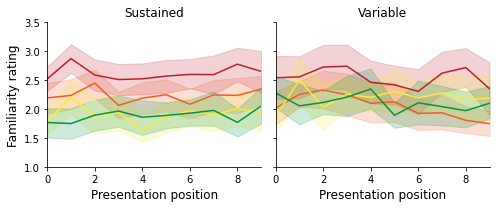

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True, sharex=True)
sns.lineplot(encoding_df(sustained), x='Order', y='Familiarity Rating', hue='Attention', ax=ax[0], legend=False, palette=attention_colors)
ax[0].set_xlabel('Presentation position', fontsize=12)
ax[0].set_ylabel('Familiarity rating', fontsize=12)
ax[0].set_title('Sustained', fontsize=12)
sns.despine(top=True, right=True)

sns.lineplot(encoding_df(variable), x='Order', y='Familiarity Rating', hue='Attention', ax=ax[1], legend=False, palette=attention_colors)
ax[1].set_xlabel('Presentation position', fontsize=12)
ax[1].set_ylabel('')
ax[1].set_title('Variable', fontsize=12)
sns.despine(top=True, right=True)

ax[0].set_xlim([0, 9])
ax[0].set_ylim([1, 3.5])
plt.tight_layout()

fig.savefig(os.path.join(figdir, 'encoding_effects.pdf'), bbox_inches='tight')

Plot familiarity as a function of recall position:
  - $x$-axis: recall position
  - $y$-axis: familiarity
  - color: attention level

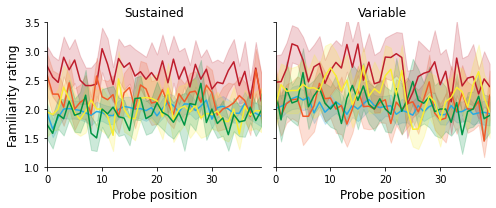

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharey=True, sharex=True)

sns.lineplot(sustained.query('`Trial Type` == "Memory"'), x='Order', y='Familiarity Rating', hue='Attention', palette=attention_colors, legend=False, ax=ax[0])
ax[0].set_xlabel('Probe position', fontsize=12)
ax[0].set_ylabel('Familiarity rating', fontsize=12)
ax[0].set_title('Sustained', fontsize=12)
sns.despine(top=True, right=True)

sns.lineplot(variable.query('`Trial Type` == "Memory"'), x='Order', y='Familiarity Rating', hue='Attention', palette=attention_colors, legend=False, ax=ax[1])
ax[1].set_xlabel('Probe position', fontsize=12)
ax[1].set_ylabel('')
ax[1].set_title('Variable', fontsize=12)
sns.despine(top=True, right=True)

ax[0].set_xlim([0, 39])
ax[0].set_ylim([1, 3.5])
plt.tight_layout()

fig.savefig(os.path.join(figdir, 'familiarity_by_probe_position.pdf'), bbox_inches='tight')



For each item, compute the number of immediately prior items (including the current item) with the same side cue, category cue, and both

In [47]:
def count_same_cues(current, all):
    previous = all.query('Subject == @current.Subject and `Trial Type` == "Presentation" and ((Run == @current.Run and Order <= @current.Order) or Run < @current.Run)').sort_values(by=['Run', 'Order'], ascending=False)
    if len(previous) == 0:
        return np.nan, np.nan, np.nan
    else:
        same_location = 0
        same_category = 0
        same_both = 0

        mismatched_location = False
        mismatched_category = False
        mismatched_both = False

        for _, row in previous.iterrows():
            if not mismatched_location and row['Cued Location'] == current['Cued Location']:
                same_location += 1
            else:
                mismatched_location = True

            if not mismatched_category and row['Cued Category'] == current['Cued Category']:
                same_category += 1
            else:
                mismatched_category = True
            
            if not mismatched_both and (row['Cued Location'] == current['Cued Location']) and (row['Cued Category'] == current['Cued Category']):
                same_both += 1
            else:
                mismatched_both = True

            if mismatched_both and mismatched_category and mismatched_location:
                break
        
        if same_both == 0:
            pass
        return same_location, same_category, same_both

Add in cue sequence information.  Note: this needs to be done on the original dataframes (before filtering out trials where the participants looked at the attended images), but those invalid trials should be filtered out again afterwards.

In [48]:
def add_cue_counts(df):
    df['Location sequence length'] = np.nan
    df['Category sequence length'] = np.nan
    df['Same cue sequence length'] = np.nan

    for i, row in tqdm(df.query('`Trial Type` == "Presentation"').iterrows()):
        df.loc[i, 'Location sequence length'] , df.loc[i, 'Category sequence length'], df.loc[i, 'Same cue sequence length'] = count_same_cues(row, df)
    
    return df

In [49]:
sustained = add_cue_counts(sustained_behavioral)
variable = add_cue_counts(variable_behavioral)

sustained = sustained[~sustained['Attended intersection']]
variable = variable[~variable['Attended intersection']]

2400it [00:05, 457.20it/s]
1840it [00:03, 493.31it/s]


In [50]:
def cue_effect_heatmaps(df, fname=None):

    attention_levels = ['Attended', 'Attended category', 'Attended location', 'Unattended']
    cue_matches = ['Same cue sequence length', 'Category sequence length', 'Location sequence length']

    fig, ax = plt.subplots(nrows=len(cue_matches), ncols=len(attention_levels), figsize=(12, 9), sharey=True, sharex='row')
    x = df.query('`Trial Type` == "Presentation"')

    for j, c in enumerate(cue_matches):
        for i, a in enumerate(attention_levels):            
            sns.histplot(data=x, x=c, y=a, discrete=True, cmap=sns.light_palette(attention_colors[a], as_cmap=True), stat='probability', common_norm=True, cbar=False, ax=ax[j, i], vmin=0, vmax=0.05)
            sns.regplot(data=x, x=c, y=a, color='k', scatter=False, ax=ax[j, i])
            ax[j, i].set_xlabel(c, fontsize=12)

            if j == 0:
                ax[j, i].set_title(a, fontsize=14)
            if i == 0:
                ax[j, i].set_ylabel('Familiarity rating', fontsize=12)
            else:
                ax[j, i].set_ylabel('')
            
            ax[j, i].set_yticks([1, 2, 3, 4])
            
            ax[j, i].set_xlim([0.5, x[c].max() + 0.5])
            ax[j, i].set_ylim([0.5, 4.5])

            vals = x[[a, c]].dropna(how='any', axis=0)
            r = pearsonr(vals[c], vals[a])
            if r.pvalue < 0.001:
                p_string = 'p < 0.001'
            else:
                p_string = f'p = {r.pvalue:.3f}'

            print(f'{a} {c} $r = {r.statistic:.3f}, {p_string}$')

    plt.tight_layout()

    if fname is not None:
        fig.savefig(os.path.join(figdir, fname + '.pdf'), bbox_inches='tight')
    
    return fig

Attended Same cue sequence length $r = 0.006, p = 0.866$
Attended category Same cue sequence length $r = -0.004, p = 0.906$
Attended location Same cue sequence length $r = 0.014, p = 0.698$
Unattended Same cue sequence length $r = -0.008, p = 0.823$
Attended Category sequence length $r = 0.021, p = 0.559$
Attended category Category sequence length $r = -0.004, p = 0.916$
Attended location Category sequence length $r = 0.035, p = 0.339$
Unattended Category sequence length $r = 0.006, p = 0.877$
Attended Location sequence length $r = 0.022, p = 0.542$
Attended category Location sequence length $r = -0.010, p = 0.788$
Attended location Location sequence length $r = -0.013, p = 0.715$
Unattended Location sequence length $r = 0.008, p = 0.833$


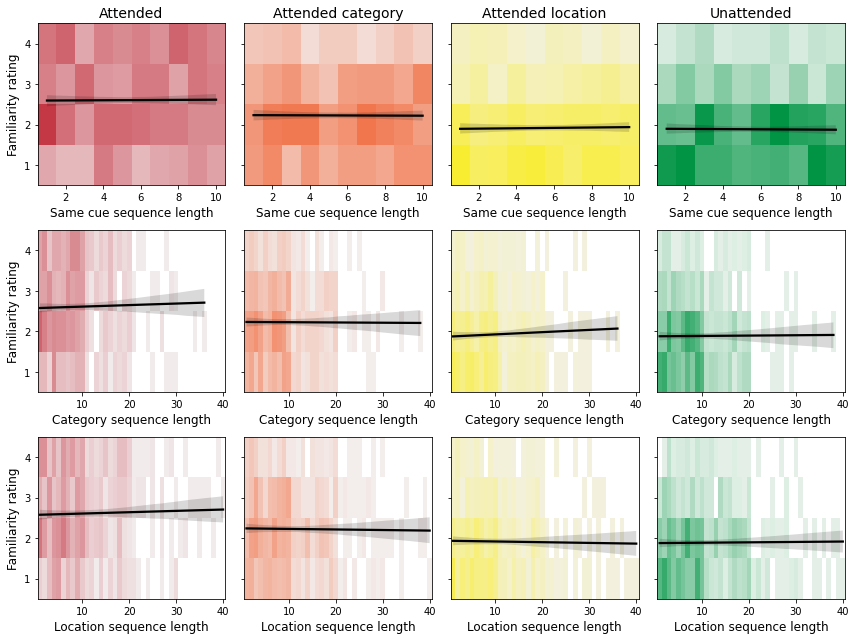

In [51]:
cue_effect_heatmaps(sustained, 'sustained_cue_effects');

Attended Same cue sequence length $r = -0.033, p = 0.475$
Attended category Same cue sequence length $r = 0.047, p = 0.294$
Attended location Same cue sequence length $r = 0.037, p = 0.427$
Unattended Same cue sequence length $r = 0.080, p = 0.073$
Attended Category sequence length $r = -0.050, p = 0.271$
Attended category Category sequence length $r = 0.066, p = 0.141$
Attended location Category sequence length $r = 0.070, p = 0.128$
Unattended Category sequence length $r = 0.116, p = 0.009$
Attended Location sequence length $r = 0.013, p = 0.779$
Attended category Location sequence length $r = -0.001, p = 0.987$
Attended location Location sequence length $r = 0.009, p = 0.837$
Unattended Location sequence length $r = 0.011, p = 0.806$


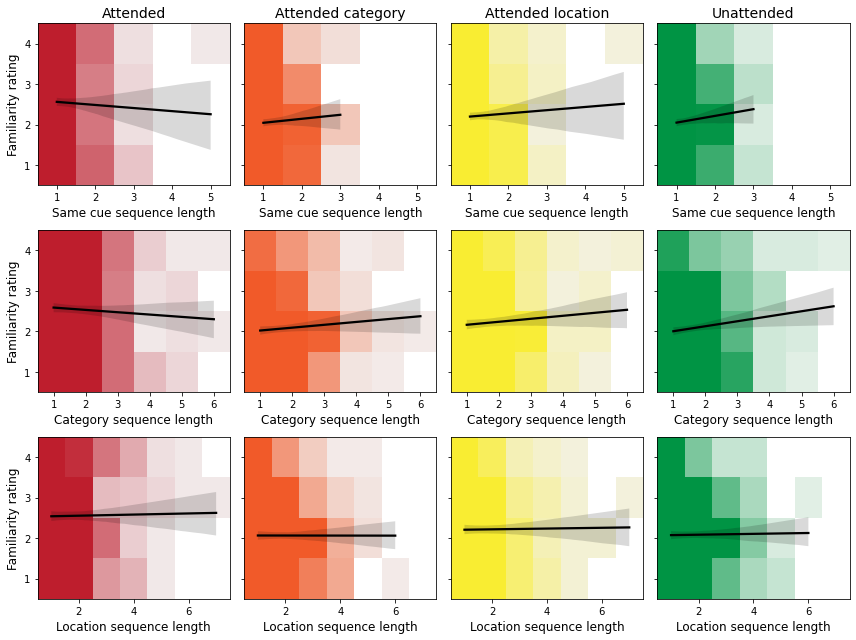

In [52]:
cue_effect_heatmaps(variable, 'variable_cue_effects');

Recency and response biases:
  - For each probe, compute the temporal distance (in image presentations) to the nearest same-category cue
  - For each probe, compute the number of same-category cues from the current run
  - For each probe, compute a recency-weighted average of the number of same-category cues on most recent run, where

$w = \argmax\left[1 - \exp\{-\frac{x}{\tau}\} , \epsilon \right]$,

and where $w$ is the weight given to the cue at presentation position $x$, $\tau = 2$, and $\epsilon = 0.05$.

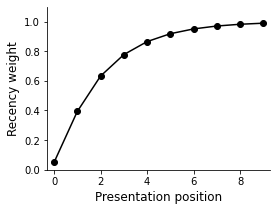

In [53]:
def recency(x, tau=2, eps=0.05, max_pos=9):
    if type(x) is not np.ndarray:
        x = np.array(x)

    y = 1 - np.exp(-x/tau)

    if type(y) is np.ndarray:
       y[y <= 0] = eps
    elif y <= 0:
       y = eps
    
    return y

fig = plt.figure(figsize=(4, 3))

x = np.linspace(0, 9, 10)
plt.plot(x, recency(x, tau=2, eps=0.05), 'ko-')
plt.xlabel('Presentation position', fontsize=12)
plt.ylabel('Recency weight', fontsize=12)
plt.ylim([0, 1.1])
plt.xlim([-0.3, 9.3])
sns.despine(top=True, right=True)

fig.savefig(os.path.join(figdir, 'recency_weights.pdf'), bbox_inches='tight')

Note: broken below this point...

In [74]:
def nearest_cues(current, all, **kwargs):
    previous = all.query('Subject == @current.Subject and `Trial Type` == "Presentation" and Run == @current.Run').sort_values(by=['Run', 'Order'], ascending=False)
    if len(previous) == 0:
        return np.nan, np.nan, np.nan

    same_category = previous['Cued Category'] == current['Category']

    nearest_match = np.where(same_category)[0]
    if len(nearest_match) == 0:
        closest = np.nan
        number_of_matches = 0
        recency_weighted_number_of_matches = 0
    else:
        closest = np.min(nearest_match) + 1
        number_of_matches = np.sum(same_category)
        recency_weighted_number_of_matches = max([min([np.sum(recency(nearest_match, **kwargs)) / sum(recency(9 - np.arange(previous.shape[0]), **kwargs)), 1]), 0])
    
    return closest, number_of_matches, recency_weighted_number_of_matches

In [75]:
def add_cue_recency_info(df):
    df['Distance to nearest same-category cue'] = np.nan
    df['Number of same-category cues'] = np.nan
    df['Recency-weighted number of same-category cues'] = np.nan

    for i, row in tqdm(df.query('`Trial Type` == "Memory"').iterrows()):
        df.loc[i, 'Distance to nearest same-category cue'], df.loc[i, 'Number of same-category cues'], df.loc[i, 'Recency-weighted number of same-category cues'] = nearest_cues(row, df)
    return df

In [76]:
sustained_behavioral = add_cue_recency_info(sustained_behavioral)
variable_behavioral = add_cue_recency_info(variable_behavioral)

sustained = sustained_behavioral[~sustained_behavioral['Attended intersection']]
variable = variable_behavioral[~variable_behavioral['Attended intersection']]

9600it [00:39, 242.74it/s]
7360it [00:30, 238.53it/s]


<Axes: >

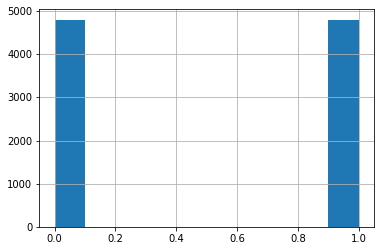

In [77]:
sustained['Recency-weighted number of same-category cues'].hist()

<Axes: >

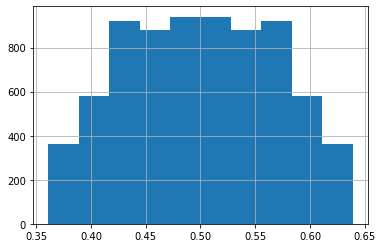

In [78]:
variable['Recency-weighted number of same-category cues'].hist()

<Axes: >

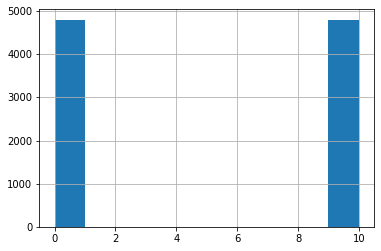

In [79]:
sustained['Number of same-category cues'].hist()

<Axes: >

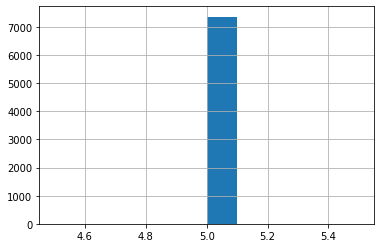

In [80]:
variable['Number of same-category cues'].hist()

<Axes: >

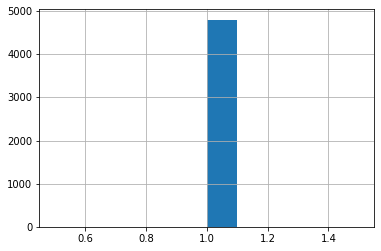

In [81]:
sustained['Distance to nearest same-category cue'].hist()

<Axes: >

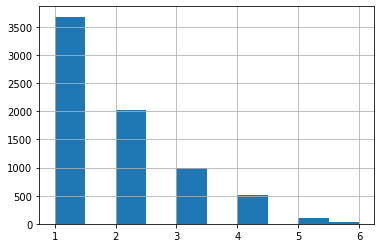

In [82]:
variable['Distance to nearest same-category cue'].hist()